# 【補足】 外れ値検知 - その他の手法

## 統計値を用いた異常検知 2  - IQR method / Winsorizing method  

IQR method / Winsorizing method について触れます。これらも統計量を利用した異常検知の一つで、具体的には四分位数を利用したものです。Zscore method でも学習したような前提条件などがありますが、データの分布に従った理解のしやすい手法であるため押さえておきましょう。 

### IQR method

IQR (Interquartile range) とは四分位範囲で、75 パーセンタイル（第3四分位数、Q3）から 25 パーセンタイル（第1四分位数、Q1）を引いた値で、データのばらつきを示すものです。通常 **-1.5 × IQR** から **1.5 × IQR** の範囲を超えた値は外れ値として扱われます。  

![03](img/04/03.png)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

今回もでもデータを用いて実装します。  

In [3]:
# データの準備
np.random.seed(0)
x = np.random.normal(0, 1, 1000)
anomaly = np.array([-5, 5])
data = np.concatenate([x, anomaly], axis=0)

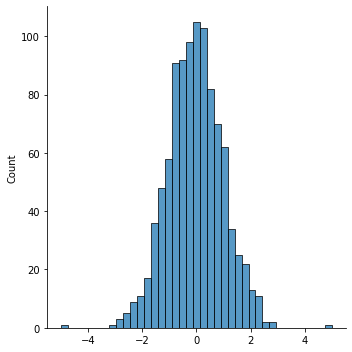

In [4]:
sns.displot(data)

In [5]:
# 関数
def iqr_outlier(x):
    out = []
    out_idx = []
    q1 = np.quantile(x, q=.25)
    q3 = np.quantile(x, q=.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for n, i in enumerate(x):
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
            out_idx.append(n)
    return out, out_idx

In [6]:
out, out_idx = iqr_outlier(data)

In [7]:
out

[-2.77259275642665,
 -2.7396771671895563,
 2.6962240525635797,
 -3.0461430547999266,
 -2.8345545052747023,
 2.594424587768152,
 2.759355114021582,
 -5.0,
 5.0]

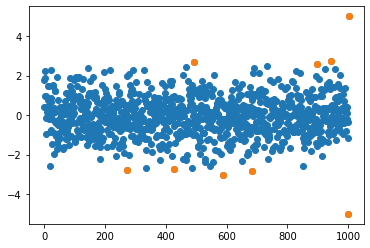

In [8]:
plt.scatter(range(len(data)), data)
plt.scatter(out_idx, data[out_idx]);

上図のオレンジ色の点が以上と判断された点です。おおよそのデータが青色の固まりのようになっているにも関わらず検出されたものはそれらから外れていることがわかります。  

### Winsorizing method  

この方法は IQR 法と非常に似た手法です。データの分布のうち、四分位範囲で、99 パーセンタイルを超える、または、 1 パーセンタイル以下の値を外れ値とみなします。

In [9]:
# 関数
def winsorization_outliers(x):
    out = []
    out_idx = []
    q1 = np.percentile(x, 1)
    q3 = np.percentile(x, 99)
    for n, i in enumerate(x):
        if i > q3 or i < q1:
            out.append(i)
            out_idx.append(n)
    return out, out_idx, q1, q3

In [10]:
out, out_idx, q1, q3 = winsorization_outliers(data)

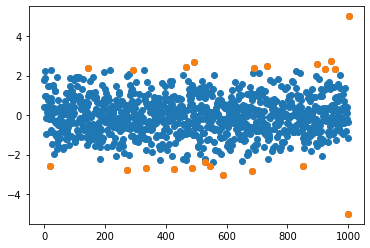

In [11]:
plt.scatter(range(len(data)), data)
plt.scatter(out_idx, data[out_idx])

## Hypothesis Testing (Smirnov‐Grubbs 検定)

次は同じ統計量を利用するものですが、その中でも仮説検定を利用する方法について触れます。  

仮説検定を扱うため帰無仮説 ($H_0$)、対立仮説 ($H_1$) を以下のように定義します。

- $H_0$ : データセットに外れ値は存在しない
- $H_1$ : データセットに外れ値が 1 つ存在する

計算された値が有意水準より大きければ、帰無仮説を棄却して、値の 1 つが異常値であると結論づけることができます。

標本数を $n$、所要の有意水準を $\alpha$、自由度 $n-2$ の $t$ 分布の $\frac{\alpha}{n}\times100$ パーセンタイルを $t$ として、

$$
\tau = \frac{(n-1)t}{\sqrt{n(n-2)+nt^2}}
$$

を有意点として、再帰的に使用します。  
つまり、最も外れた 1 標本のみを検定し、それが外れ値と判断されたら、その外れ値を除外した $n-1$ 個の標本を使って 2 番目の外れた標本を検定し、外れ値が検出されなくなるまで繰り返します。

In [1]:
import numpy as np
import scipy.stats as stats

In [2]:
# サンプルデータ

# 外れ値無し
A = np.array([10, 11, 12, 17, 19, 21])
# 外れ値有り
B = np.array([10, 11, 12, 17, 19, 21, 43])

In [3]:
# 関数
def grubbs_test_outlier(data, alpha=0.05):
    x, outliers = list(data), []
    while True:
        global i_far
        n = len(x)
        t = stats.t.isf(q=(alpha/n)/2, df=n-2)
        tau = (n-1) * t / np.sqrt(n*(n-2)+n*t*t)
        i_min, i_max = np.argmin(x), np.argmax(x)
        mean, std = np.mean(x), np.std(x, ddof=1)
        if np.abs(x[i_max]-mean) > np.abs(x[i_min]-mean):
            i_far = i_max
        else:
            i_min
        tau_far = np.abs((x[i_far]-mean)/std)
        if tau_far < tau:
            break
        outliers.append(x.pop(i_far))
    return x, outliers

In [4]:
# A:外れ値無しの場合
_, out = grubbs_test_outlier(A)
print('外れ値', out)

外れ値 []


In [5]:
# B:外れ値有りの場合
_, out = grubbs_test_outlier(B)
print('外れ値', out)

外れ値 [43]
